In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline  
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve


In [2]:
df = pd.read_csv(r"C:\Users\DHONI HANIF\OneDrive\Documents\AI_Collection_and_Loss_Reverse_Forecast\modelling\nasabah\clustering\data\data_for_classification.csv")
df.sample(5)

,Unnamed: 0,net_income,loan_amount,amount_of_late,late_payment_amount,credit_score,arrears_amounts,loss_reverse,credit_risk
2307,2307,10500000.0,5.666667e+07,54.0,2.0,392.0,1.0,1.416667e+07,Tidak tertagih dengan resiko tinggi
1245,1245,15500000.0,5.916667e+07,103.0,7.0,223.0,2.0,2.958333e+07,Tertagih dengan resiko tinggi
2321,2321,10500000.0,5.883333e+07,18.0,1.0,371.0,1.0,1.470833e+07,Tidak tertagih dengan resiko tinggi
1333,1333,19000000.0,5.983333e+07,100.0,6.0,234.0,3.0,4.487500e+07,Tertagih dengan resiko tinggi
361,361,16500000.0,6.133333e+07,96.0,6.0,234.0,2.0,3.066667e+07,Tertagih dengan resiko tinggi


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           5000 non-null   int64  
 1   net_income           5000 non-null   float64
 2   loan_amount          5000 non-null   float64
 3   amount_of_late       5000 non-null   float64
 4   late_payment_amount  5000 non-null   float64
 5   credit_score         5000 non-null   float64
 6   arrears_amounts      5000 non-null   float64
 7   loss_reverse         5000 non-null   float64
 8   credit_risk          5000 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 351.7+ KB


In [4]:
for i in df.columns:
    if df[i].dtype == "object":
        df[i] = df[i].astype("category")

df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [5]:
# Preprocessing untuk fitur kategori
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

# Preprocessing untuk fitur numerik
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])
numeric_features = ["net_income", "loan_amount", "amount_of_late", "late_payment_amount", "credit_score", "arrears_amounts", "loss_reverse"]

drop_features = ["debtor_name", "debtor_nik", "debtor_address", "debtor_number", "debtor_company", 
                 "debtor_gender", "employment_type", "payment_date", "number_of_dependents", "aset", "bil1_late1", "bill_late2",
                 "bill_late3", "bill_late4", "bill_late5", "bill_late6", "bill_late7", "bill_late8", 
                 "bill_late9", "bill_late10", "bill_late11", "bill_late12", "arrears1", "arrears2",
                 "arrears3", "arrears4", "arrears5", "arrears6", "arrears7", "arrears8", "arrears9", "arrears10",
                 "arrears11", "arrears12", "debtor_zip", "debtor_rt", "debtor_rw", "debtor_birth_place",
                 "debtor_age", "debtor_occupation", "debtor_marital_status", "debtor_education_level", "aging", "tenor"]

# Gabungkan transformer dengan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('drop', 'drop', drop_features)
    ])



In [6]:
X = df.drop("credit_risk", axis=1)
y = df["credit_risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
bagging = joblib.load("bagging2.pkl")
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', bagging)
])
joblib.dump(model, "credit_risk.joblib")
# model.fit(X_train, y_train)

['credit_risk.joblib']

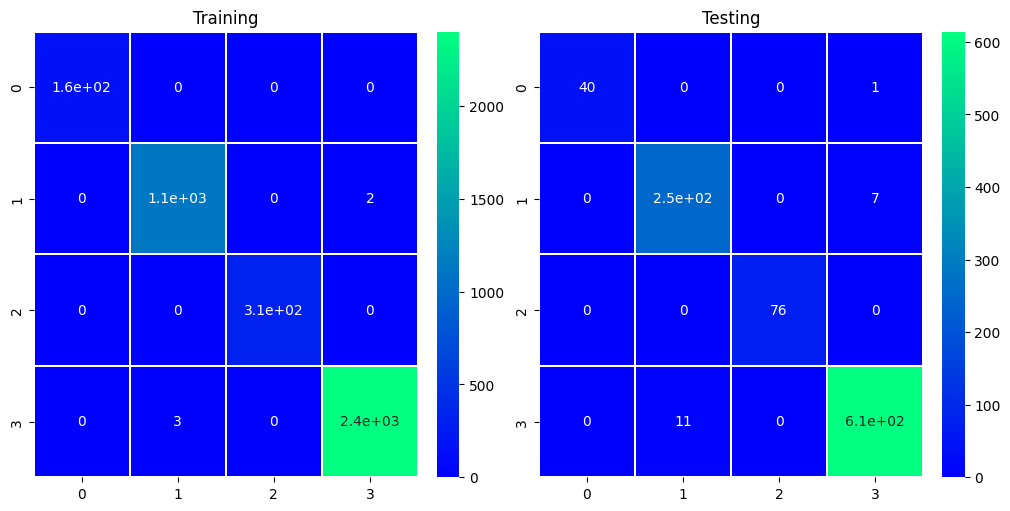

In [7]:
y_pred = model.predict(X_test)
fig, ax = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
sns.heatmap(confusion_matrix(y_train, model.predict(X_train)), annot=True, linecolor="white", linewidths=0.2, cmap="winter", ax=ax[0])
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, linecolor="white", linewidths=0.2, cmap="winter", ax=ax[1])

ax[0].set_title("Training")
ax[1].set_title("Testing")
plt.show()

In [8]:
y_pred

array(['Tertagih dengan resiko tinggi',
       'Tidak tertagih dengan resiko tinggi',
       'Tidak tertagih dengan resiko tinggi',
       'Tertagih dengan resiko tinggi', 'Tertagih dengan resiko tinggi',
       'Tidak tertagih dengan resiko rendah',
       'Tidak tertagih dengan resiko tinggi',
       'Tidak tertagih dengan resiko tinggi',
       'Tidak tertagih dengan resiko tinggi',
       'Tidak tertagih dengan resiko tinggi',
       'Tidak tertagih dengan resiko tinggi',
       'Tidak tertagih dengan resiko tinggi',
       'Tidak tertagih dengan resiko tinggi',
       'Tidak tertagih dengan resiko tinggi',
       'Tidak tertagih dengan resiko tinggi',
       'Tertagih dengan resiko tinggi', 'Tertagih dengan resiko rendah',
       'Tertagih dengan resiko tinggi',
       'Tidak tertagih dengan resiko tinggi',
       'Tidak tertagih dengan resiko tinggi',
       'Tidak tertagih dengan resiko tinggi',
       'Tertagih dengan resiko tinggi', 'Tertagih dengan resiko tinggi',
       'Tid

In [9]:
joblib.dump(model, "credit_risk.joblib")

['credit_risk.joblib']

In [10]:
model = joblib.load("credit_risk.joblib")
a = X_test.iloc[-1]

a = pd.DataFrame({i: [j] for i, j in zip(a.index, a.values)})
model.predict(a)

array(['Tidak tertagih dengan resiko tinggi'], dtype=object)

In [11]:
y_test.iloc[-1]

'Tidak tertagih dengan resiko tinggi'